## Rough volatility: fact or artefact?

### Libraries and global settings

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math

from ipywidgets import interact
from ipywidgets import widgets
from tqdm.auto import tqdm

from typing import Union

from roughvol import normvar, utils

### Plot settings

In [14]:
sns.set(rc={"figure.figsize":(17, 9)})

#### Generators

In [8]:
from fbm import FBM

In [15]:
def brownian_motion(time:          Union[float, np.ndarray],
                    n_simulations: int) -> np.ndarray:
        increments = np.random.normal(0, 1, [n_simulations, *np.shape(time)])
    
        brownian_motion = np.zeros((n_simulations, *np.shape(time)))
        for i in tqdm(range(1, *np.shape(time))):
            brownian_motion[:, i] = brownian_motion[:, i-1] + increments[:, i-1]*np.sqrt(time[i]-time[i-1])

        return brownian_motion

In [16]:
def simulate_paths_heston_euler(time: Union[float, np.ndarray],
                                n_simulations: int,
                                state: normvar.MarketState,
                                heston_params: normvar.HestonParameters,
                                random_state: int=None) -> dict:
    r, s0 = state.interest_rate, state.stock_price

    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, heston_params.vbar, heston_params.gamma
    Z1         = np.random.normal(size=(n_simulations, np.shape(time)[0]))
    Z2         = np.random.normal(size=(n_simulations, np.shape(time)[0]))

    V          = np.zeros([n_simulations, np.shape(time)[0]])
    V[:, 0]    = v0

    logS       = np.zeros([n_simulations, np.shape(time)[0]])
    logS[:, 0] = np.log(s0) 

    for ind in range(0, np.shape(time)[0]-1):
        logS[:, ind+1] = logS[:, ind] + (r - 0.5 * V[:, ind]) * (time[ind+1] - time[ind]) + np.sqrt(np.abs(V[:, ind])*(time[ind+1] - time[ind])) * Z1[:, ind]
        V[:, ind+1]    = np.abs(V[:, ind] + kappa*(vbar - V[:, ind])*(time[ind+1] - time[ind]) + gamma*np.sqrt(np.abs(V[:, ind])*(time[ind+1] - time[ind]))*(rho*Z1[:, ind]+np.sqrt(1-rho**2)*Z2[:, ind]))

    return {"price": np.exp(logS), "volatility": V}

In [ ]:
def fractional_brownian_motion(time: Union[float, np.ndarray], 
                               n_simulations: int,
                               H: float = 0.5,
                               ) -> np.ndarray:
    fBm = np.zeros((n_simulations, time.size+1))
    f = FBM(n=time.size, hurst=H, length=time.size, method='daviesharte')
    for i in tqdm(range(n_simulations)):
        fBm[i] = f.fbm()
    return fBm

### Monte-Carlo Roughness Estimation

#### $W$ Statistic Illustration

In [7]:
sz    = 1000
time  = np.arange(10000)
res   = np.zeros(sz)
array = brownian_motion(time, 1)[0]
step  = int(time.size*0.01)

X     = np.linspace(2.0, 5.0, 500)
Y     = np.zeros(X.size)

for i in tqdm(range(X.size)):
    Y[i] = normvar.sample_normalized_variation(array[time[np.arange(0, time.size, step)]], time[np.arange(0, time.size, step)], array, time, X[i])

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

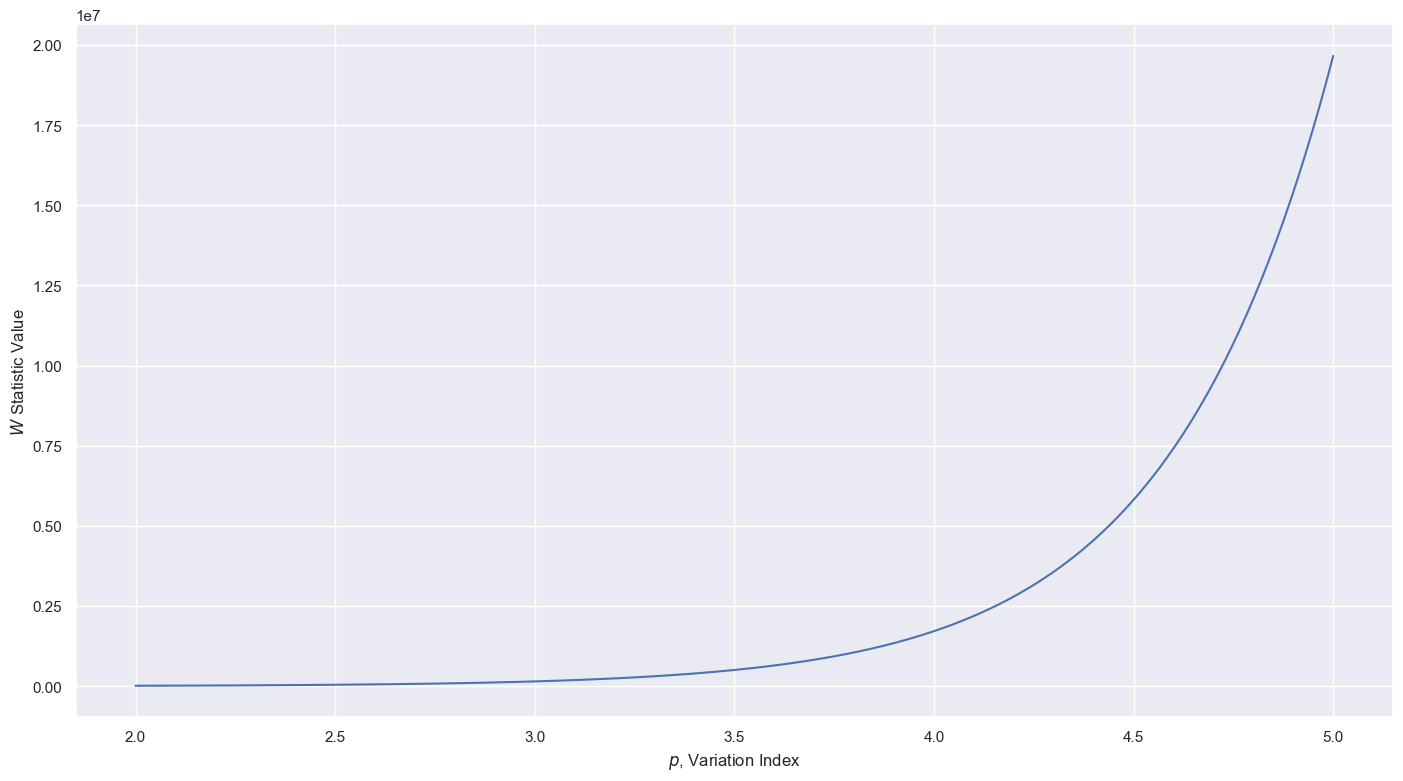

In [8]:
sns.lineplot(x=X, y=Y)
plt.ylabel("$W$ Statistic Value") 
plt.xlabel("$p$, Variation Index")
plt.savefig('fig2/W Stat Illustration.pdf')
plt.show()

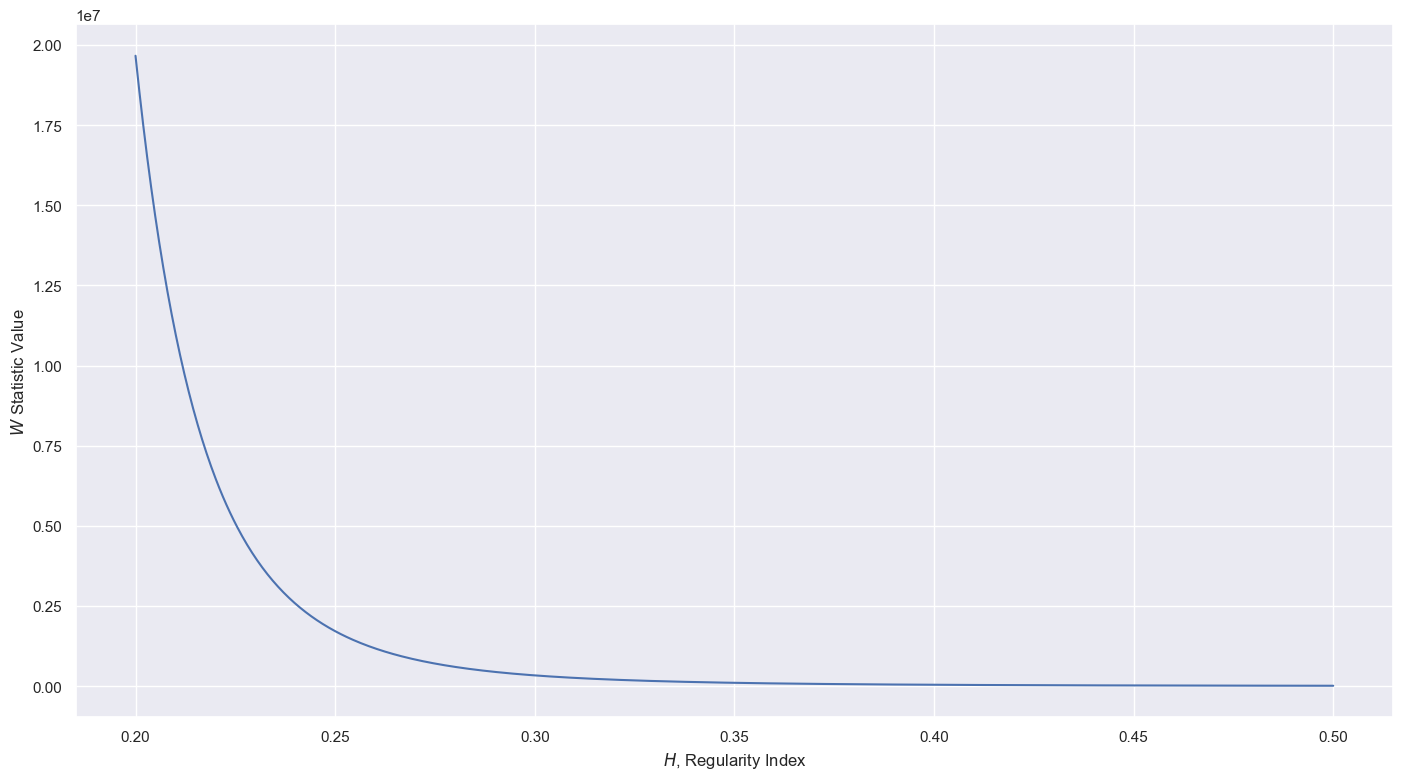

In [9]:
sns.lineplot(x=1/X, y=Y)
plt.ylabel("$W$ Statistic Value") 
plt.xlabel("$H$, Regularity Index")
plt.show()

#### Brownian Motion

In [10]:
sz_bm     = 100
time_bm   = np.linspace(0, 100, 4000)
res_bm    = np.zeros(sz_bm)
bm_mc  = brownian_motion(time_bm, sz_bm)

for i in tqdm(range(sz_bm)):
    res_bm[i] = normvar.sample_roughness(bm_mc[i], time_bm)

  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

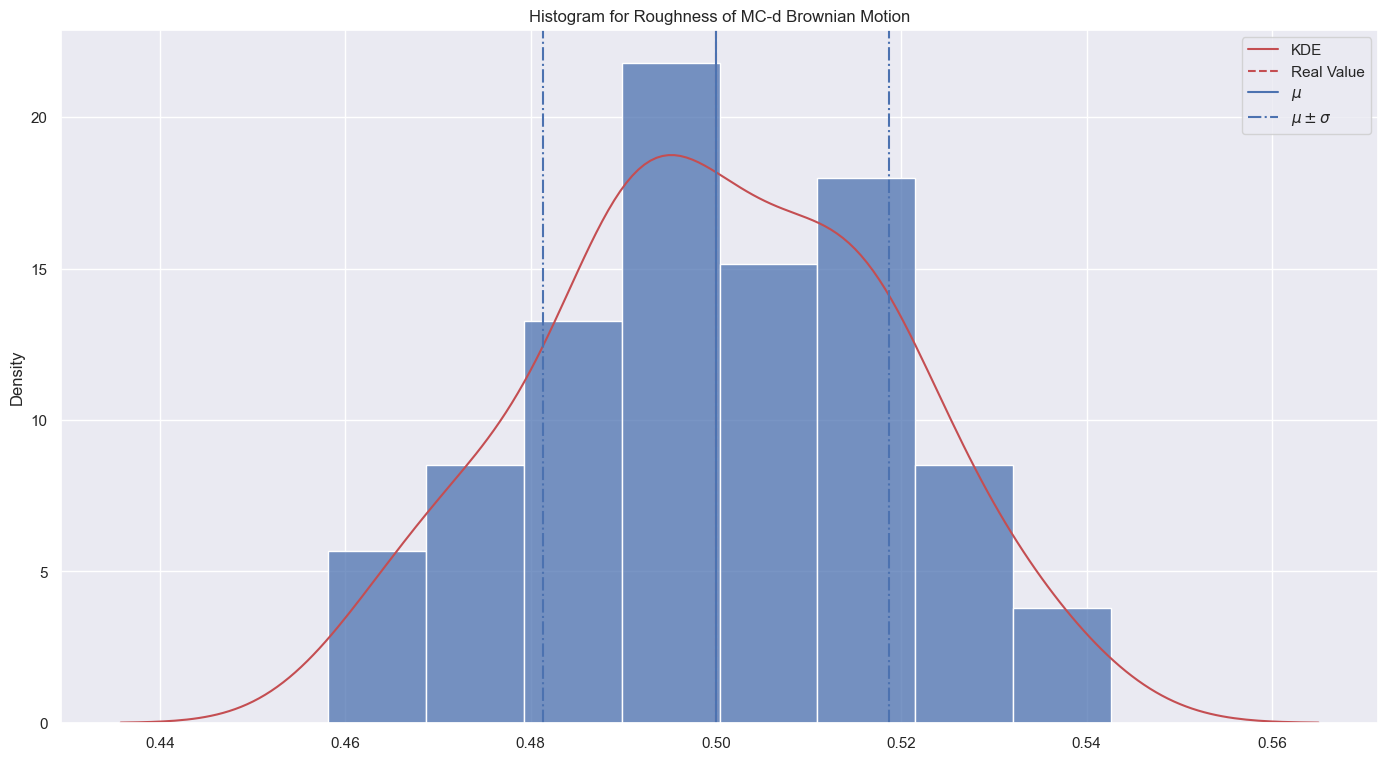

mean: 0.4999760842945614, std: 0.018675297247938868


In [17]:
utils.custom_hist(res_bm, 'Histogram for Roughness of MC-d Brownian Motion', 0.5, save=True)

#### Fractional Brownian Motion (Davies-Harte Method)

In [18]:
sz_fbm   = 100
time_fbm = np.linspace(0, 1000, 4000)

def simulate_price_fbm(H: float = 0.5):
    res_fbm  = np.zeros(sz_fbm)
    print('Simulating FBM with Hurst parameter: ', H, '...')
    fbm_mc = fractional_brownian_motion(time = time_fbm, n_simulations=sz_fbm, H=H)
    print('Done. \nCalculating sample roughness...')
    for i in tqdm(range(sz_fbm)):
        res_fbm[i] = normvar.sample_roughness(fbm_mc[i], time_fbm)
        
    normvar.custom_hist(res_fbm, f'Histogram. Roughness of Fractional Brownian Motion with H = {H}, {res_fbm.size} Monte-Carlo Simulations', H, save=True)

Simulating FBM with Hurst parameter:  0.15 ...


100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


Done. 
Calculating sample roughness...


100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


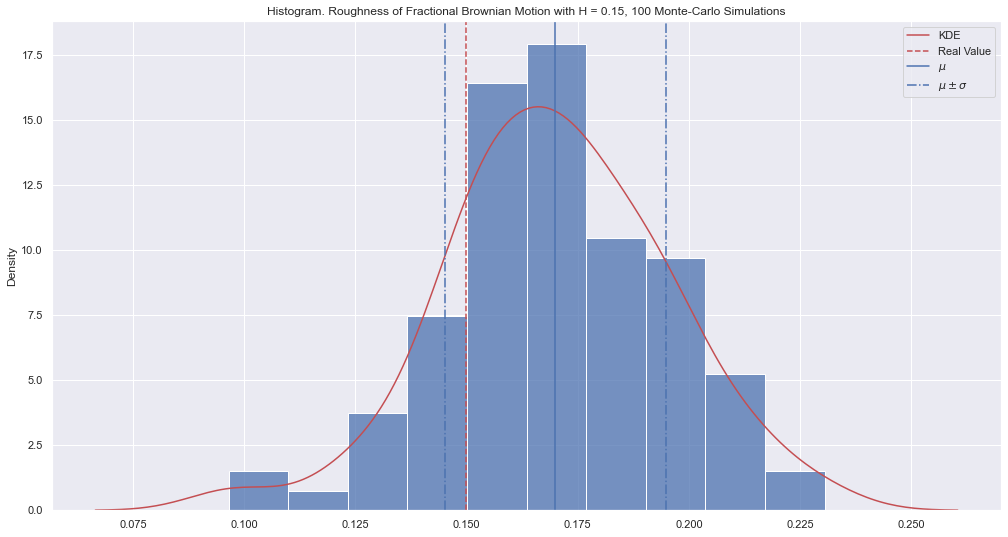

mean: 0.1700220946071621, std: 0.02494861804640474
Simulating FBM with Hurst parameter:  0.35 ...


100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


Done. 
Calculating sample roughness...


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


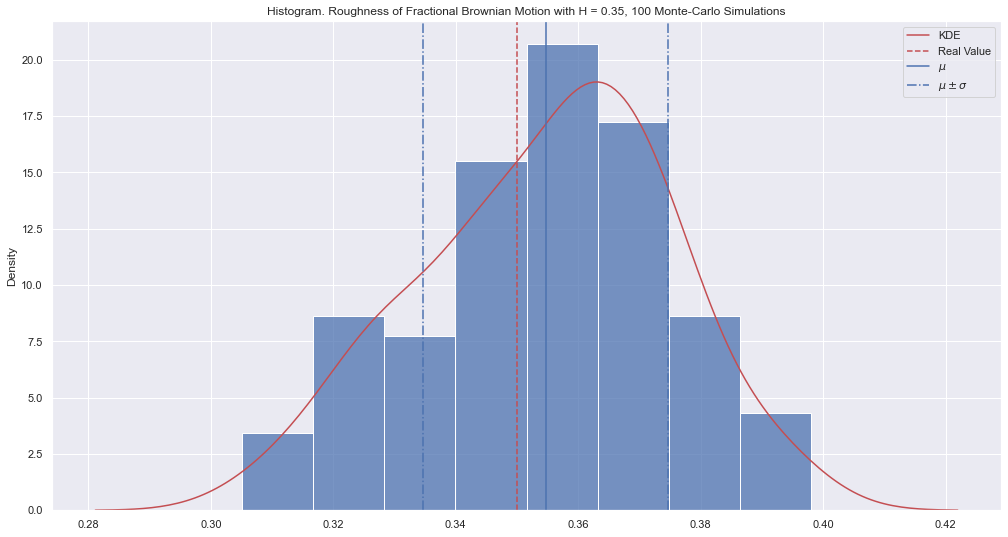

mean: 0.3546944835586865, std: 0.019992420765734573
Simulating FBM with Hurst parameter:  0.5499999999999999 ...


100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


Done. 
Calculating sample roughness...


100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


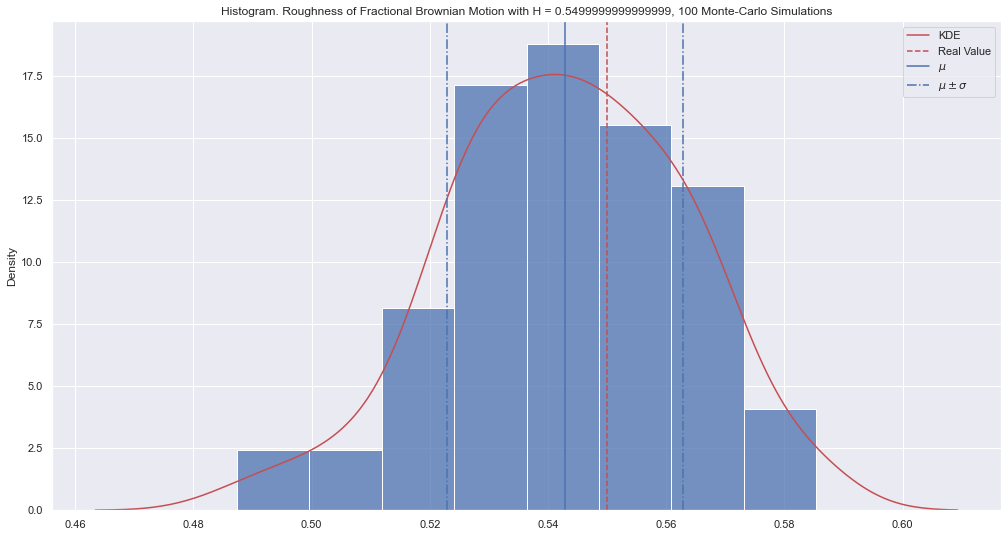

mean: 0.5428877410912265, std: 0.019960047080605087
Simulating FBM with Hurst parameter:  0.75 ...


100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


Done. 
Calculating sample roughness...


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


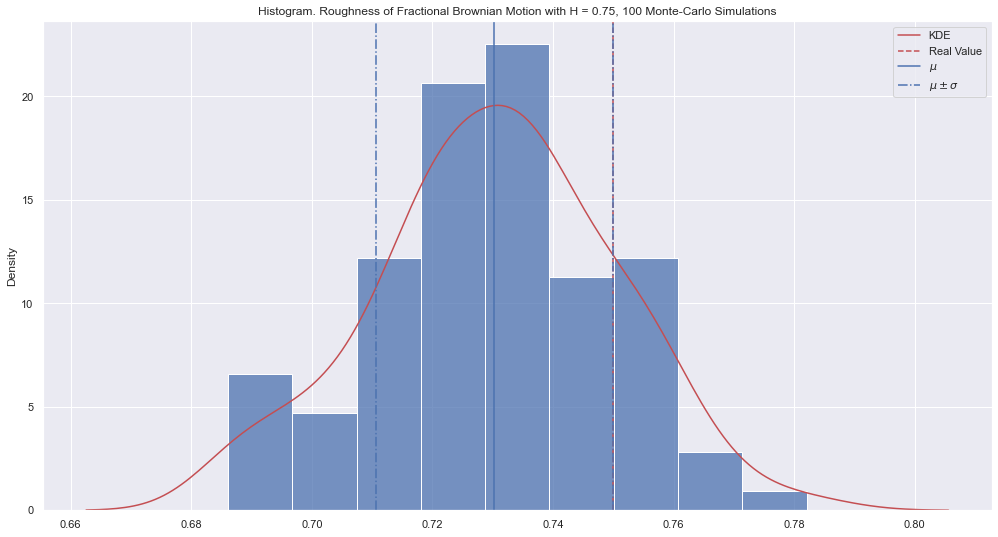

mean: 0.7302746726964524, std: 0.01961367497868969


In [19]:
for H in np.arange(0.15, 0.9, 0.2):
    simulate_price_fbm(H)

#### Heston Simulation (Euler Scheme)

In [20]:
time_hest = np.linspace(0, 1, 4000)
sz_hest   = 100

dictr = simulate_paths_heston_euler(time_hest, sz_hest, MarketState(100, 0.05), HestonParameters(1, 1, -0.5, 1, 1), random_state=None)
S, V = dictr['price'], dictr['volatility']

res_vo, res_rv = np.zeros(sz_hest), np.zeros(sz_hest)
for i in tqdm(range(sz_hest)):
    rv_heston = rlz_vol_est(S[i], 10)
    res_vo[i] = sample_roughness(V[i], np.arange(V[i].size))
    res_rv[i] = sample_roughness(rv_heston, np.arange(rv_heston.size))

100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


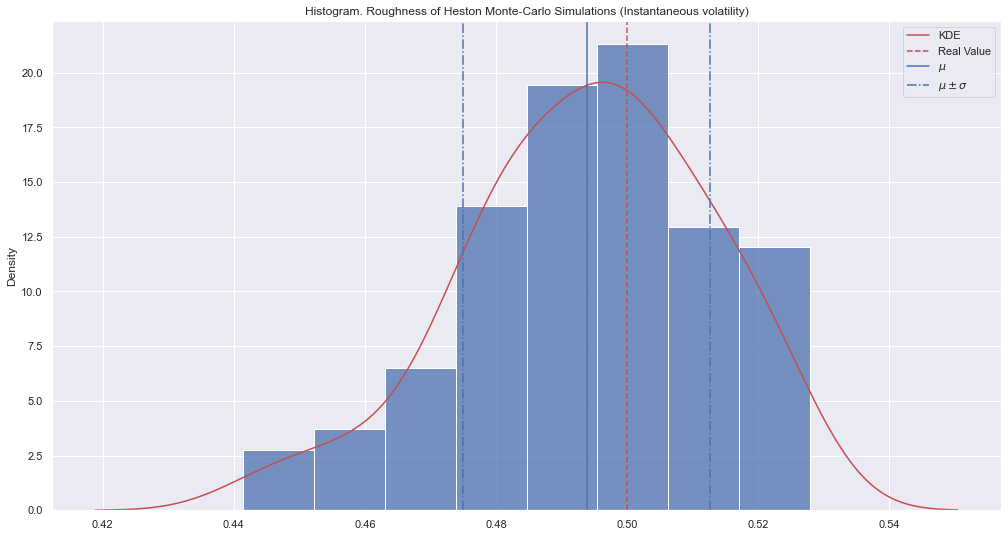

mean: 0.49382095211509985, std: 0.01878938431603392


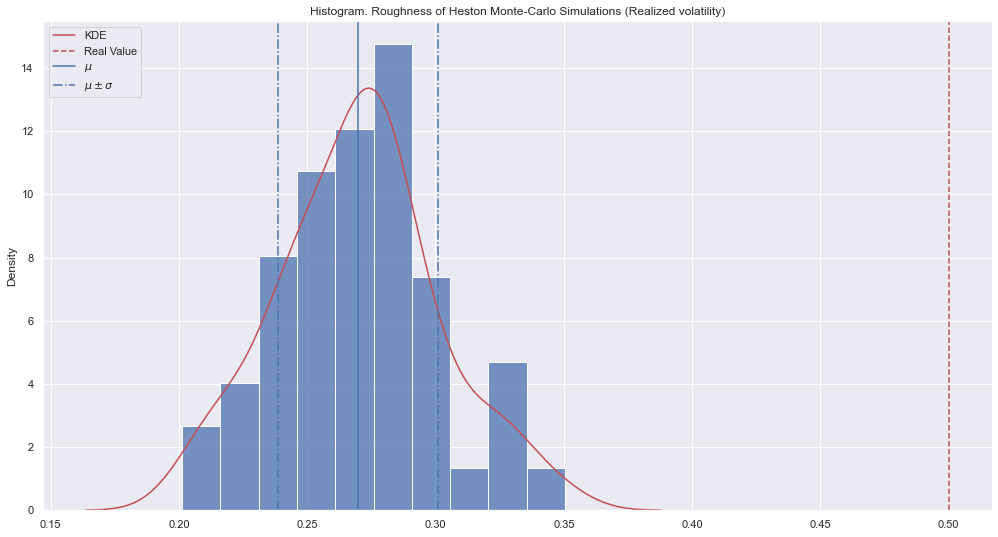

mean: 0.269867104723226, std: 0.031144215861540963


In [21]:
custom_hist(res_vo, 'Histogram. Roughness of Heston Monte-Carlo Simulations (Instantaneous volatility)', 0.5, save=True)
custom_hist(res_rv, 'Histogram. Roughness of Heston Monte-Carlo Simulations (Realized volatility)', 0.5, save=True)

#### RFSV Simulation

In [22]:
def simulate_price_rfsv(time: Union[float, np.ndarray], 
                        n_simulations: int,
                        r:     float = 0.0,    # rate of return
                        H:     float = 0.5,    # Hurst parameter
                        nu:    float = 0.0,    # volatility of volatility
                        alpha: float = 1.0,    # reversion rate
                        m:     float = 1.0,    # mean reversion parameter
                        ) -> np.ndarray:
    fgn = np.zeros((n_simulations, time.size))
    f = FBM(n=time.size, hurst=H, length=time.size, method='daviesharte')
    for i in tqdm(range(n_simulations)):
        fgn[i] = f.fgn()
    Xt = np.zeros_like(fgn)
    for i in range(1, time.size):
        Xt[:, i] = Xt[:, i-1] + nu*fgn[:, i] + alpha*(m-Xt[:, i-1])
    volatility = np.exp(Xt)

    increments = np.random.normal(0, 1, [n_simulations, *np.shape(time)])

    S = np.zeros_like(volatility)
    for i in range(1, time.size):
        S[:, i] = S[:, i-1] + (r-0.5*np.power(volatility[:, i-1], 2))*(time[i]-time[i-1]) + volatility[:, i-1]*increments[:, i]*np.sqrt(time[i]-time[i-1])
    return np.exp(S)*100, volatility

In [23]:
price, volatility = simulate_price_rfsv(time=np.linspace(0, 40, 4000), n_simulations=100, r=0.05, H=0.1, nu=.01, alpha=1, m=.2)

100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


In [24]:
res_rfsv = np.zeros(100)
vol_rfsv = np.zeros(100)

for i in tqdm(range(100)):
    rv_rsfv = utils.rlz_vol_est(price[i], 10)
    res_rfsv[i] = normvar.sample_roughness(rv_rsfv, np.linspace(0, 40, rv_rsfv.size))
    vol_rfsv[i] = normvar.sample_roughness(volatility[i], np.linspace(0, 40, volatility[i].size))

 21%|██        | 21/100 [00:21<01:40,  1.27s/it]C:\Users\Artemy\AppData\Local\Temp\ipykernel_18064\2064906380.py:11: RuntimeWarning: overflow encountered in power
  array             = np.power(np.abs(np.diff(array)), p)
C:\Users\Artemy\AppData\Local\Temp\ipykernel_18064\2064906380.py:16: RuntimeWarning: overflow encountered in power
  div = np.sum(np.power(normalizing_array[np.arange(np.where(sampling_frequency == block_frequency[i])[0], np.where(sampling_frequency == block_frequency[i+1])[0])], p))
C:\Users\Artemy\AppData\Local\Temp\ipykernel_18064\2064906380.py:22: RuntimeWarning: invalid value encountered in double_scalars
  sample_norm_var += array[i] * (block_frequency[i+1] - block_frequency[i]) / div
100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


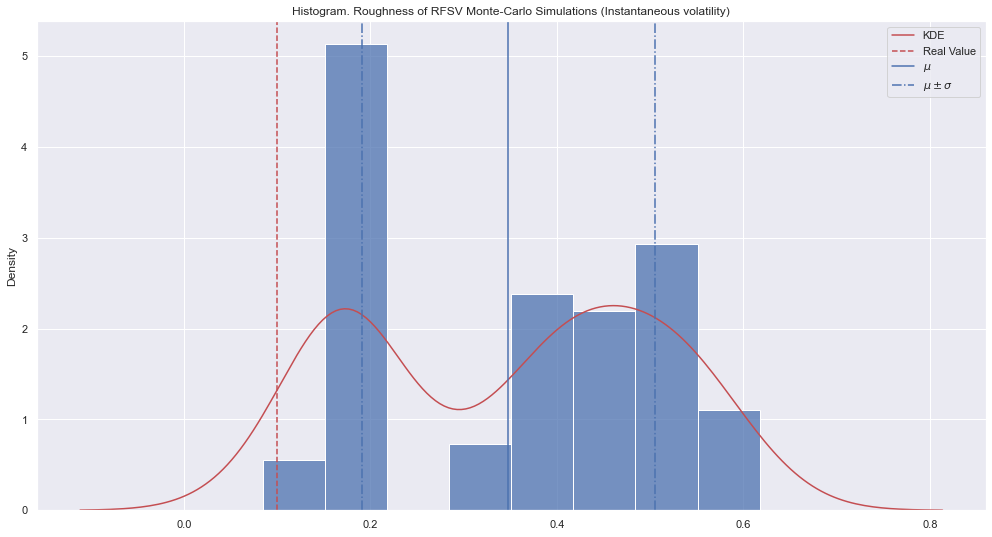

mean: 0.34799197604492815, std: 0.1568202225123922


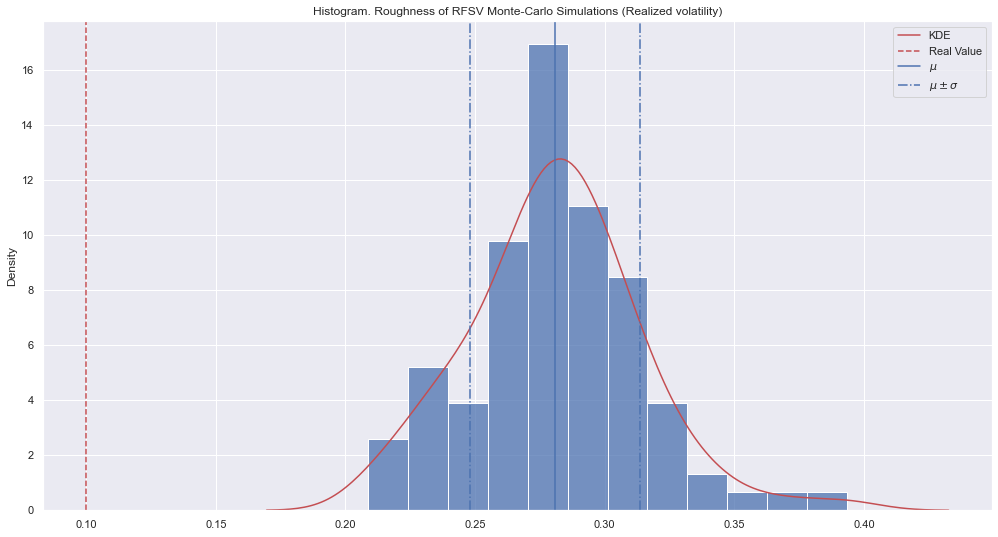

mean: 0.2807962462589286, std: 0.0327327349573785


In [25]:
utils.custom_hist(vol_rfsv, 'Histogram. Roughness of RFSV Monte-Carlo Simulations (Instantaneous volatility)', 0.1, save=True)
utils.custom_hist(res_rfsv, 'Histogram. Roughness of RFSV Monte-Carlo Simulations (Realized volatility)', 0.1, save=True)

### Bloomberg Data Roughness Estimation

In [18]:
RX_Equities = np.array(["YNDX RX Equity", 
                        "SBER RX Equity", 
                        "VTBR RX Equity", 
                        "MOEX RX Equity", 
                        "LKOH RX Equity", 
                        "GAZP RX Equity", 
                        "FIVE RX Equity"])

LI_Equities = np.array(["OGZD LI Equity", 
                        "VTBR LI Equity", 
                        "SBER LI Equity", 
                        "LKOD LI Equity"])
                        
Equities    = np.concatenate((RX_Equities, LI_Equities))

In [19]:
res_bbb = np.zeros(Equities.size)

In [20]:
def min(a:float, b:float):
    if a > b:
        return b
    return a

In [23]:
i = 0
for ticker in tqdm(Equities):
    df = pd.read_csv(f'data_bloomberg/{ticker}.csv', sep='\t')[::-1].reset_index(drop = True)
    df["Mean"] = 0.5*(df.High + df.Low).to_numpy()
    df.Dates = pd.to_datetime(df.Dates)

    rlz_vol  = utils.rlz_vol_est(df['Mean'].to_numpy()[np.arange(min(80000, df['Mean'].to_numpy().size))], 20)
    res_bbb[i] = normvar.sample_roughness(rlz_vol, np.arange(rlz_vol.size))
    i+=1

  0%|          | 0/11 [00:00<?, ?it/s]

In [43]:
def export_report_as_tex(names: np.ndarray, roughnesses: np.ndarray):
    with open("roughness.tex", "x") as f:
        f.write('\\begin{table}[h]\n')
        f.write('\t\\begin{tabular}{|c|c|c|c|c|c|}\n')
        f.write('\t\t\\hline\n')
        f.write('\t\tTicker &  Roughness Index\\\\\\hline\n\t\t\\hline\n')
        for i in range(names.size):
            f.write(f'\t\t{names[i]} & {round(roughnesses[i], 6)}\\\\\\hline\n')

        f.write('\t\\end{tabular}\n')
        f.write('\t\\caption{Roughness index estimations}\n')
        f.write('\t\\label{tab:roughness_indexes}\n')
        f.write('\\end{table}\n')

In [45]:
export_report_as_tex(Equities, res_bbb)

In [24]:
res_bbb

array([0.37269066, 0.31310916, 0.30467741, 0.29537848, 0.30179538,
       0.31612541, 0.28470406, 2.96860766, 0.30676304, 1.17661556,
       0.30606108])